# Breakdown the Poisson Equation and Compute EACH Term Explicitly from LES

## Boussinesq

\begin{equation}
\nabla ^2 \frac{p}{\rho_0} = \frac{\partial{b}}{\partial{z}}-[(\frac{\partial{u}}{\partial{x}})^2+(\frac{\partial{v}}{\partial{y}})^2+(\frac{\partial{w}}{\partial{z}})^2]-2[\frac{\partial{v}}{\partial{x}}\frac{\partial{u}}{\partial{y}}+\frac{\partial{w}}{\partial{x}}\frac{\partial{u}}{\partial{z}}+\frac{\partial{w}}{\partial{y}}\frac{\partial{v}}{\partial{z}}]
\end{equation}

## Simplified as 
\begin{equation}
 \nabla^2{\frac{p'}{\rho}}=\frac{\partial{b}}{\partial{z}}-2\Big[\Big(\frac{\partial{w}}{\partial{z}}\Big)^2+w\frac{\partial^2{w}}{\partial{z}^2}\Big]
\end{equation}

# $\overline{\Big(\frac{\partial{p}}{\partial{z}}\Big)}_i = \frac{2}{\pi}\Big[1+(\frac{H}{2R})^2\Big]^{-1}b_0\sin{lz}-\frac{\pi}{H}(w_0\sin{lz})(w_0\cos{lz}) $

# * $\overline{\Big(\frac{\partial{p}}{\partial{z}}\Big)}_i \sim \Big[1+\big(\frac{H}{2R}\big)^{2}\Big]^{-1}\overline{b}_i-\frac{{\pi}^2}{4}\overline{w}_i\frac{\partial{\overline{w}_i}}{\partial{z}}-\frac{{\pi}^2}{4}\frac{\overline{w}_i^2}{a_i}\frac{\partial{a}_i}{\partial{z}}$    ? and       $(?+\frac{{\pi}^2}{4}\overline{w}_i[w]_{int})$

## <that is, ** $\overline{\Big(\frac{\partial{p}}{\partial{z}}\Big)}_i \sim \frac{\alpha_1}{1+\alpha_2\big(\frac{H}{2R}\big)^{2}}\overline{b}_i-\beta\big[\frac{1}{a_i}\frac{\partial}{\partial{z}}(a_i\overline{w}_i^2)-\gamma\frac{1}{2}\frac{\partial\overline{w}_i^2}{\partial{z}}\big]$

In [1]:
# module import
import numpy as np
import pandas as pd
import netCDF4 as nc
from sklearn.linear_model import LinearRegression
from scipy.optimize import least_squares
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.insert(0,'/export/home/jiahe/CliMA/tools/misc/')
import masking
import json

sns.set()

In [2]:
def select_upd(i):
    if i == 1:
        xidx = np.arange(30,55,1)
        yidx = np.arange(110,150,1)
        zidx = np.arange(26,44,1)
    elif i == 2:
        xidx = np.arange(285,311,1)
        yidx = np.arange(180,206,1)
        zidx = np.arange(16,34,1)
    elif i == 3:
        xidx = np.arange(45,71,1)
        yidx = np.arange(150,176,1)
        zidx = np.arange(43,64,1)
    else:
        print('only vavid for updrafts 1, 2, 3')
        return

    return xidx, yidx, zidx


In [3]:
# load stat data and namelist
namelist = json.loads(open('/export/data1/jiahe/LESdata/Output.Bomex.test4/Bomex.in').read())
dx = namelist['grid']['dx']
dy = namelist['grid']['dy']
dz = namelist['grid']['dz']
nx = namelist['grid']['nx']
ny = namelist['grid']['ny']
nz = namelist['grid']['nz']

# x y in meters
x = np.arange(dx*0.5,nx*dx,dx)
y = np.arange(dy*0.5,ny*dy,dy)
# x y index
XX = np.arange(nx)
YY = np.arange(ny)

stat = nc.Dataset('/export/data1/jiahe/LESdata/Output.Bomex.test4/stats/Stats.Bomex.nc')
z_half = stat.groups['profiles'].variables['z_half'][:].data
z_full = stat.groups['profiles'].variables['z'][:].data
alpha0 = stat.groups['reference'].variables['alpha0'][:].data
rho0 = stat.groups['reference'].variables['rho0'][:].data

# load field data
data = nc.Dataset('/export/data1/jiahe/LESdata/Output.Bomex.test4/comb_fields/21600.nc')
p_centr = data.groups['fields'].variables['dynamic_pressure'][:].data
ql_centr = data.groups['fields'].variables['ql'][:].data
w_edge = data.groups['fields'].variables['w'][:].data
# u_edge = data.groups['fields'].variables['u'][:].data
# v_edge = data.groups['fields'].variables['v'][:].data
c_srf = data.groups['fields'].variables['c_srf_15'][:].data
b_centr = data.groups['fields'].variables['buoyancy'][:].data
br_centr = b_centr - b_centr.reshape(nx*ny,nz).mean(axis=0)

w_centr = np.zeros_like(w_edge)
w_centr[:,:,0] = 0.5*w_edge[:,:,0]
for k in np.arange(1, nz):
    w_centr[:,:,k] = 0.5*(w_edge[:,:,k-1]+w_edge[:,:,k])

In [4]:
# mask updrafts for the entire simulation domain
c_srf_2d = c_srf.reshape(nx*ny,nz)
ql2d = ql_centr.reshape(nx*ny,nz)
w2d_full = w_centr.reshape(nx*ny,nz)
w2d_half = masking.interpolate_w(w2d_full)
cb_idx, ct_idx = masking.calculate_cloud_base_top(ql2d)
mask2d = masking.updraft_env_mask(c_srf_2d, w2d_half, ql2d, cb_idx, ct_idx, z_half)
mask3d = {}
for item in mask2d:
    mask3d[item] = mask2d[item].reshape(nx,ny,nz)

## Updraft 1

In [5]:
# updraft filter
xidx, yidx, zidx = select_upd(1)
xmesh = np.repeat(xidx,len(yidx)).reshape(len(xidx),len(yidx))
ymesh = np.repeat(yidx,len(xidx)).reshape(len(yidx),len(xidx)).transpose()
mask3d_upd = mask3d['updraft'][xmesh,ymesh,:]

br_upd = np.ma.masked_where(mask3d_upd, br_centr[xmesh,ymesh,:]).mean(axis=0).mean(axis=0)
w_upd = np.ma.masked_where(mask3d_upd, w_centr[xmesh,ymesh,:]).mean(axis=0).mean(axis=0)
w_upd_sq = w_upd**2
a_upd = 1-mask3d_upd.sum(axis=0).sum(axis=0)/float(len(xidx)*len(yidx))

# compute derivatives
pz = np.zeros_like(p_centr)
dwudz = np.zeros(nz)
dwu2dz = np.zeros(nz)
dawu2dz = np.zeros(nz)
az = np.zeros(nz)
for k in np.arange(1,nz-1):
    pz[:,:,k] = 0.5*(alpha0[k+1]*p_centr[:,:,k+1]-alpha0[k-1]*p_centr[:,:,k-1])/float(dz)
    dwudz[k] = 0.5*(w_upd[k+1]-w_upd[k-1])/float(dz)
    dwu2dz[k] = 0.5*(w_upd_sq[k+1]-w_upd_sq[k-1])/float(dz)
    dawu2dz[k] = 0.5*(a_upd[k+1]*w_upd_sq[k+1]-a_upd[k-1]*w_upd_sq[k-1])/float(dz)
    az[k] = 0.5*(a_upd[k+1]-a_upd[k-1])/float(dz)
pz_upd = np.ma.masked_where(mask3d_upd, pz[xmesh,ymesh,:]).mean(axis=0).mean(axis=0)

H = (a_upd[zidx]!=0).sum() * dz
R = np.sqrt(a_upd*len(xidx)*len(yidx)/3.1415926)

/home/jiahe/.virtualenvs/diag/lib/python2.7/site-packages/ipykernel_launcher.py:20: UserWarning: Warning: converting a masked element to nan.
/home/jiahe/.virtualenvs/diag/lib/python2.7/site-packages/ipykernel_launcher.py:21: UserWarning: Warning: converting a masked element to nan.
/home/jiahe/.virtualenvs/diag/lib/python2.7/site-packages/ipykernel_launcher.py:22: UserWarning: Warning: converting a masked element to nan.
/home/jiahe/.virtualenvs/diag/lib/python2.7/site-packages/ipykernel_launcher.py:20: UserWarning: Warning: converting a masked element to nan.
/home/jiahe/.virtualenvs/diag/lib/python2.7/site-packages/ipykernel_launcher.py:21: UserWarning: Warning: converting a masked element to nan.
/home/jiahe/.virtualenvs/diag/lib/python2.7/site-packages/ipykernel_launcher.py:22: UserWarning: Warning: converting a masked element to nan.
/home/jiahe/.virtualenvs/diag/lib/python2.7/site-packages/ipykernel_launcher.py:20: UserWarning: Warning: converting a masked element to nan.
/home/

/home/jiahe/.virtualenvs/diag/lib/python2.7/site-packages/ipykernel_launcher.py:20: UserWarning: Warning: converting a masked element to nan.
/home/jiahe/.virtualenvs/diag/lib/python2.7/site-packages/ipykernel_launcher.py:21: UserWarning: Warning: converting a masked element to nan.
/home/jiahe/.virtualenvs/diag/lib/python2.7/site-packages/ipykernel_launcher.py:22: UserWarning: Warning: converting a masked element to nan.
/home/jiahe/.virtualenvs/diag/lib/python2.7/site-packages/ipykernel_launcher.py:20: UserWarning: Warning: converting a masked element to nan.
/home/jiahe/.virtualenvs/diag/lib/python2.7/site-packages/ipykernel_launcher.py:21: UserWarning: Warning: converting a masked element to nan.
/home/jiahe/.virtualenvs/diag/lib/python2.7/site-packages/ipykernel_launcher.py:22: UserWarning: Warning: converting a masked element to nan.
/home/jiahe/.virtualenvs/diag/lib/python2.7/site-packages/ipykernel_launcher.py:20: UserWarning: Warning: converting a masked element to nan.
/home/

In [6]:
# fit the equation: (dp/dz)i = α1 / [1+α2*{aspect_ratio}^2] * b_i - β [1/a_i d(a_i w_i^2)/dz - 1/2 d(w_i^2)/dz]
upd1 = pd.DataFrame(pz_upd[zidx], columns=['pz'])
upd1['br'] = br_upd[zidx]
upd1['aspect_ratio'] = 0.5*H/R[zidx]
upd1['area_w'] = dawu2dz[zidx]/a_upd[zidx]
upd1['half_dwu2dz'] = 0.5*dwu2dz[zidx]
upd1['zidx'] = zidx

upd1 = upd1.dropna()

def fun(coeff, x, y):
    return coeff[0]*x['br']/(1+coeff[1]*x['aspect_ratio']**2) - coeff[2]*x['area_w'] - y

lsq1_1 = least_squares(fun, [0.75,0.5,0.5], args=(upd1[['br','aspect_ratio','area_w']], upd1['pz']))
upd1['pz_pred1'] = lsq1_1.x[0]*upd1['br']/(1+lsq1_1.x[1]*upd1['aspect_ratio']**2)-lsq1_1.x[2]*upd1['area_w']

def fun(coeff, x, y):
    return coeff[0]*x['br']/(1+coeff[1]*x['aspect_ratio']**2) - coeff[2]*(x['area_w']-x['half_dwu2dz']) - y

lsq1_2 = least_squares(fun, [0.75,0.5,0.5], args=(upd1[['br','aspect_ratio','area_w','half_dwu2dz']], upd1['pz']))
upd1['pz_pred2'] = lsq1_2.x[0]*upd1['br']/(1+lsq1_2.x[1]*upd1['aspect_ratio']**2)-lsq1_2.x[2]*(upd1['area_w']-upd1['half_dwu2dz'])

upd1['b_coeff1'] = lsq1_1.x[0]/(1+lsq1_1.x[1]*upd1['aspect_ratio']**2)
upd1['b_coeff2'] = lsq1_2.x[0]/(1+lsq1_2.x[1]*upd1['aspect_ratio']**2)


/home/jiahe/.virtualenvs/diag/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in divide
  after removing the cwd from sys.path.


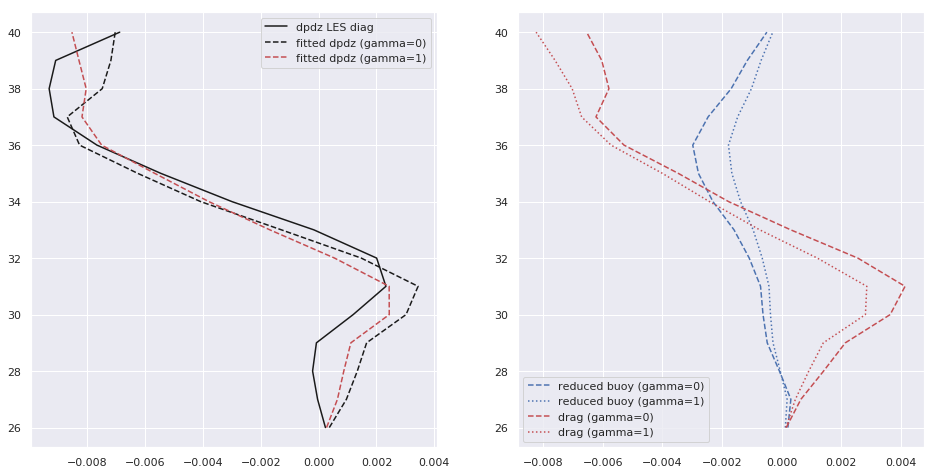

In [7]:
# plot updraft 1 
fig, ax = plt.subplots(1,2,figsize=(16,8))

ax[0].plot(-upd1['pz'], upd1['zidx'], 'k')
ax[0].plot(-upd1['pz_pred1'], upd1['zidx'], 'k--')
ax[0].plot(-upd1['pz_pred2'], upd1['zidx'], 'r--')
ax[0].legend(['dpdz LES diag','fitted dpdz (gamma=0)','fitted dpdz (gamma=1)'])

ax[1].plot(-upd1['b_coeff1']*upd1['br'], upd1['zidx'], 'b--')
ax[1].plot(-upd1['b_coeff2']*upd1['br'], upd1['zidx'], 'b:')
ax[1].plot(lsq1_1.x[2]*upd1['area_w'], upd1['zidx'], 'r--')
ax[1].plot(lsq1_2.x[2]*(upd1['area_w']-upd1['half_dwu2dz']), upd1['zidx'], 'r:')
ax[1].legend(['reduced buoy (gamma=0)','reduced buoy (gamma=1)','drag (gamma=0)','drag (gamma=1)'])

plt.show()


## Updraft 2

In [8]:
# updraft filter
xidx, yidx, zidx = select_upd(2)
xmesh = np.repeat(xidx,len(yidx)).reshape(len(xidx),len(yidx))
ymesh = np.repeat(yidx,len(xidx)).reshape(len(yidx),len(xidx)).transpose()
mask3d_upd = mask3d['updraft'][xmesh,ymesh,:]

br_upd = np.ma.masked_where(mask3d_upd, br_centr[xmesh,ymesh,:]).mean(axis=0).mean(axis=0)
w_upd = np.ma.masked_where(mask3d_upd, w_centr[xmesh,ymesh,:]).mean(axis=0).mean(axis=0)
w_upd_sq = w_upd**2
a_upd = 1-mask3d_upd.sum(axis=0).sum(axis=0)/float(len(xidx)*len(yidx))

# compute derivatives
pz = np.zeros_like(p_centr)
dwudz = np.zeros(nz)
dwu2dz = np.zeros(nz)
dawu2dz = np.zeros(nz)
az = np.zeros(nz)
for k in np.arange(1,nz-1):
    pz[:,:,k] = 0.5*(alpha0[k+1]*p_centr[:,:,k+1]-alpha0[k-1]*p_centr[:,:,k-1])/float(dz)
    dwudz[k] = 0.5*(w_upd[k+1]-w_upd[k-1])/float(dz)
    dwu2dz[k] = 0.5*(w_upd_sq[k+1]-w_upd_sq[k-1])/float(dz)
    dawu2dz[k] = 0.5*(a_upd[k+1]*w_upd_sq[k+1]-a_upd[k-1]*w_upd_sq[k-1])/float(dz)
    az[k] = 0.5*(a_upd[k+1]-a_upd[k-1])/float(dz)
pz_upd = np.ma.masked_where(mask3d_upd, pz[xmesh,ymesh,:]).mean(axis=0).mean(axis=0)

H = (a_upd[zidx]!=0).sum() * dz
R = np.sqrt(a_upd*len(xidx)*len(yidx)/3.1415926)

/home/jiahe/.virtualenvs/diag/lib/python2.7/site-packages/ipykernel_launcher.py:20: UserWarning: Warning: converting a masked element to nan.
/home/jiahe/.virtualenvs/diag/lib/python2.7/site-packages/ipykernel_launcher.py:21: UserWarning: Warning: converting a masked element to nan.
/home/jiahe/.virtualenvs/diag/lib/python2.7/site-packages/ipykernel_launcher.py:22: UserWarning: Warning: converting a masked element to nan.
/home/jiahe/.virtualenvs/diag/lib/python2.7/site-packages/ipykernel_launcher.py:20: UserWarning: Warning: converting a masked element to nan.
/home/jiahe/.virtualenvs/diag/lib/python2.7/site-packages/ipykernel_launcher.py:21: UserWarning: Warning: converting a masked element to nan.
/home/jiahe/.virtualenvs/diag/lib/python2.7/site-packages/ipykernel_launcher.py:22: UserWarning: Warning: converting a masked element to nan.
/home/jiahe/.virtualenvs/diag/lib/python2.7/site-packages/ipykernel_launcher.py:20: UserWarning: Warning: converting a masked element to nan.
/home/

/home/jiahe/.virtualenvs/diag/lib/python2.7/site-packages/ipykernel_launcher.py:20: UserWarning: Warning: converting a masked element to nan.
/home/jiahe/.virtualenvs/diag/lib/python2.7/site-packages/ipykernel_launcher.py:21: UserWarning: Warning: converting a masked element to nan.
/home/jiahe/.virtualenvs/diag/lib/python2.7/site-packages/ipykernel_launcher.py:22: UserWarning: Warning: converting a masked element to nan.
/home/jiahe/.virtualenvs/diag/lib/python2.7/site-packages/ipykernel_launcher.py:20: UserWarning: Warning: converting a masked element to nan.
/home/jiahe/.virtualenvs/diag/lib/python2.7/site-packages/ipykernel_launcher.py:21: UserWarning: Warning: converting a masked element to nan.
/home/jiahe/.virtualenvs/diag/lib/python2.7/site-packages/ipykernel_launcher.py:22: UserWarning: Warning: converting a masked element to nan.
/home/jiahe/.virtualenvs/diag/lib/python2.7/site-packages/ipykernel_launcher.py:20: UserWarning: Warning: converting a masked element to nan.
/home/

In [9]:
# fit the equation: (dp/dz)i = α1 / [1+α2*{aspect_ratio}^2] * b_i - β [1/a_i d(a_i w_i^2)/dz - 1/2 d(w_i^2)/dz]
upd2 = pd.DataFrame(pz_upd[zidx], columns=['pz'])
upd2['br'] = br_upd[zidx]
upd2['aspect_ratio'] = 0.5*H/R[zidx]
upd2['area_w'] = dawu2dz[zidx]/a_upd[zidx]
upd2['half_dwu2dz'] = 0.5*dwu2dz[zidx]
upd2['zidx'] = zidx

upd2 = upd2.dropna()

def fun(coeff, x, y):
    return coeff[0]*x['br']/(1+coeff[1]*x['aspect_ratio']**2) - coeff[2]*x['area_w'] - y

lsq2_1 = least_squares(fun, [0.75,0.5,0.5], args=(upd2[['br','aspect_ratio','area_w']], upd2['pz']))
upd2['pz_pred1'] = lsq2_1.x[0]*upd2['br']/(1+lsq2_1.x[1]*upd2['aspect_ratio']**2)-lsq2_1.x[2]*upd2['area_w']

def fun(coeff, x, y):
    return coeff[0]*x['br']/(1+coeff[1]*x['aspect_ratio']**2) - coeff[2]*(x['area_w']-x['half_dwu2dz']) - y

lsq2_2 = least_squares(fun, [0.75,0.5,0.5], args=(upd2[['br','aspect_ratio','area_w','half_dwu2dz']], upd2['pz']))
upd2['pz_pred2'] = lsq2_2.x[0]*upd2['br']/(1+lsq2_2.x[1]*upd2['aspect_ratio']**2)-lsq2_2.x[2]*(upd2['area_w']-upd2['half_dwu2dz'])

upd2['b_coeff1'] = lsq2_1.x[0]/(1+lsq2_1.x[1]*upd2['aspect_ratio']**2)
upd2['b_coeff2'] = lsq2_2.x[0]/(1+lsq2_2.x[1]*upd2['aspect_ratio']**2)


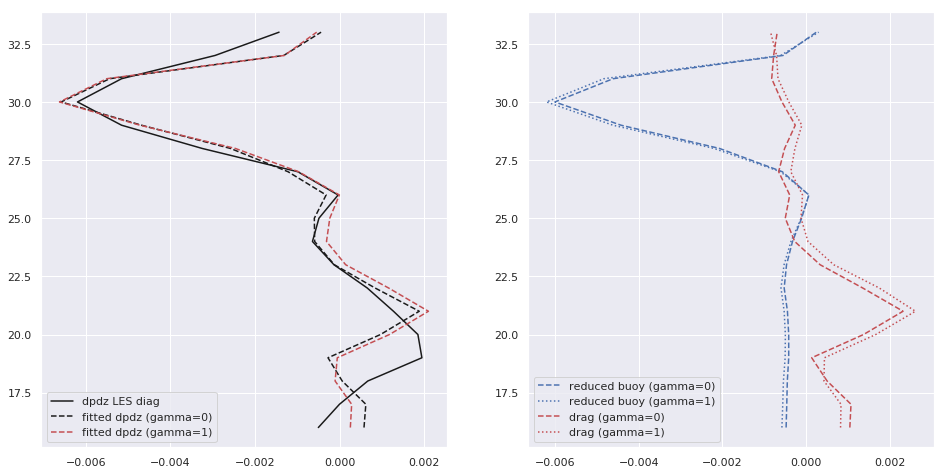

In [10]:
# plot updraft 2 
fig, ax = plt.subplots(1,2,figsize=(16,8))

ax[0].plot(-upd2['pz'], upd2['zidx'], 'k')
ax[0].plot(-upd2['pz_pred1'], upd2['zidx'], 'k--')
ax[0].plot(-upd2['pz_pred2'], upd2['zidx'], 'r--')
ax[0].legend(['dpdz LES diag','fitted dpdz (gamma=0)','fitted dpdz (gamma=1)'])

ax[1].plot(-upd2['b_coeff1']*upd2['br'], upd2['zidx'], 'b--')
ax[1].plot(-upd2['b_coeff2']*upd2['br'], upd2['zidx'], 'b:')
ax[1].plot(lsq2_1.x[2]*upd2['area_w'], upd2['zidx'], 'r--')
ax[1].plot(lsq2_2.x[2]*(upd2['area_w']-upd2['half_dwu2dz']), upd2['zidx'], 'r:')
ax[1].legend(['reduced buoy (gamma=0)','reduced buoy (gamma=1)','drag (gamma=0)','drag (gamma=1)'])

plt.show()


## Updraft 3

In [11]:
# updraft filter
xidx, yidx, zidx = select_upd(3)
xmesh = np.repeat(xidx,len(yidx)).reshape(len(xidx),len(yidx))
ymesh = np.repeat(yidx,len(xidx)).reshape(len(yidx),len(xidx)).transpose()
mask3d_upd = mask3d['updraft'][xmesh,ymesh,:]

br_upd = np.ma.masked_where(mask3d_upd, br_centr[xmesh,ymesh,:]).mean(axis=0).mean(axis=0)
w_upd = np.ma.masked_where(mask3d_upd, w_centr[xmesh,ymesh,:]).mean(axis=0).mean(axis=0)
w_upd_sq = w_upd**2
a_upd = 1-mask3d_upd.sum(axis=0).sum(axis=0)/float(len(xidx)*len(yidx))

# compute derivatives
pz = np.zeros_like(p_centr)
dwudz = np.zeros(nz)
dwu2dz = np.zeros(nz)
dawu2dz = np.zeros(nz)
az = np.zeros(nz)
for k in np.arange(1,nz-1):
    pz[:,:,k] = 0.5*(alpha0[k+1]*p_centr[:,:,k+1]-alpha0[k-1]*p_centr[:,:,k-1])/float(dz)
    dwudz[k] = 0.5*(w_upd[k+1]-w_upd[k-1])/float(dz)
    dwu2dz[k] = 0.5*(w_upd_sq[k+1]-w_upd_sq[k-1])/float(dz)
    dawu2dz[k] = 0.5*(a_upd[k+1]*w_upd_sq[k+1]-a_upd[k-1]*w_upd_sq[k-1])/float(dz)
    az[k] = 0.5*(a_upd[k+1]-a_upd[k-1])/float(dz)
pz_upd = np.ma.masked_where(mask3d_upd, pz[xmesh,ymesh,:]).mean(axis=0).mean(axis=0)

H = (a_upd[zidx]!=0).sum() * dz
R = np.sqrt(a_upd*len(xidx)*len(yidx)/3.1415926)

/home/jiahe/.virtualenvs/diag/lib/python2.7/site-packages/ipykernel_launcher.py:20: UserWarning: Warning: converting a masked element to nan.
/home/jiahe/.virtualenvs/diag/lib/python2.7/site-packages/ipykernel_launcher.py:21: UserWarning: Warning: converting a masked element to nan.
/home/jiahe/.virtualenvs/diag/lib/python2.7/site-packages/ipykernel_launcher.py:22: UserWarning: Warning: converting a masked element to nan.
/home/jiahe/.virtualenvs/diag/lib/python2.7/site-packages/ipykernel_launcher.py:20: UserWarning: Warning: converting a masked element to nan.
/home/jiahe/.virtualenvs/diag/lib/python2.7/site-packages/ipykernel_launcher.py:21: UserWarning: Warning: converting a masked element to nan.
/home/jiahe/.virtualenvs/diag/lib/python2.7/site-packages/ipykernel_launcher.py:22: UserWarning: Warning: converting a masked element to nan.
/home/jiahe/.virtualenvs/diag/lib/python2.7/site-packages/ipykernel_launcher.py:20: UserWarning: Warning: converting a masked element to nan.
/home/

/home/jiahe/.virtualenvs/diag/lib/python2.7/site-packages/ipykernel_launcher.py:20: UserWarning: Warning: converting a masked element to nan.
/home/jiahe/.virtualenvs/diag/lib/python2.7/site-packages/ipykernel_launcher.py:21: UserWarning: Warning: converting a masked element to nan.
/home/jiahe/.virtualenvs/diag/lib/python2.7/site-packages/ipykernel_launcher.py:22: UserWarning: Warning: converting a masked element to nan.
/home/jiahe/.virtualenvs/diag/lib/python2.7/site-packages/ipykernel_launcher.py:20: UserWarning: Warning: converting a masked element to nan.
/home/jiahe/.virtualenvs/diag/lib/python2.7/site-packages/ipykernel_launcher.py:21: UserWarning: Warning: converting a masked element to nan.
/home/jiahe/.virtualenvs/diag/lib/python2.7/site-packages/ipykernel_launcher.py:22: UserWarning: Warning: converting a masked element to nan.
/home/jiahe/.virtualenvs/diag/lib/python2.7/site-packages/ipykernel_launcher.py:20: UserWarning: Warning: converting a masked element to nan.
/home/

In [12]:
# fit the equation: (dp/dz)i = α1 / [1+α2*{aspect_ratio}^2] * b_i - β [1/a_i d(a_i w_i^2)/dz - 1/2 d(w_i^2)/dz]
upd3 = pd.DataFrame(pz_upd[zidx], columns=['pz'])
upd3['br'] = br_upd[zidx]
upd3['aspect_ratio'] = 0.5*H/R[zidx]
upd3['area_w'] = dawu2dz[zidx]/a_upd[zidx]
upd3['half_dwu2dz'] = 0.5*dwu2dz[zidx]
upd3['zidx'] = zidx

upd3 = upd3.dropna()

def fun(coeff, x, y):
    return coeff[0]*x['br']/(1+coeff[1]*x['aspect_ratio']**2) - coeff[2]*x['area_w'] - y

lsq3_1 = least_squares(fun, [0.75,0.5,0.5], args=(upd3[['br','aspect_ratio','area_w']], upd3['pz']))
upd3['pz_pred1'] = lsq3_1.x[0]*upd3['br']/(1+lsq3_1.x[1]*upd3['aspect_ratio']**2)-lsq3_1.x[2]*upd3['area_w']

def fun(coeff, x, y):
    return coeff[0]*x['br']/(1+coeff[1]*x['aspect_ratio']**2) - coeff[2]*(x['area_w']-x['half_dwu2dz']) - y

lsq3_2 = least_squares(fun, [0.75,0.5,0.5], args=(upd3[['br','aspect_ratio','area_w','half_dwu2dz']], upd3['pz']))
upd3['pz_pred2'] = lsq3_2.x[0]*upd3['br']/(1+lsq3_2.x[1]*upd3['aspect_ratio']**2)-lsq3_2.x[2]*(upd3['area_w']-upd3['half_dwu2dz'])

upd3['b_coeff1'] = lsq3_1.x[0]/(1+lsq3_1.x[1]*upd3['aspect_ratio']**2)
upd3['b_coeff2'] = lsq3_2.x[0]/(1+lsq3_2.x[1]*upd3['aspect_ratio']**2)


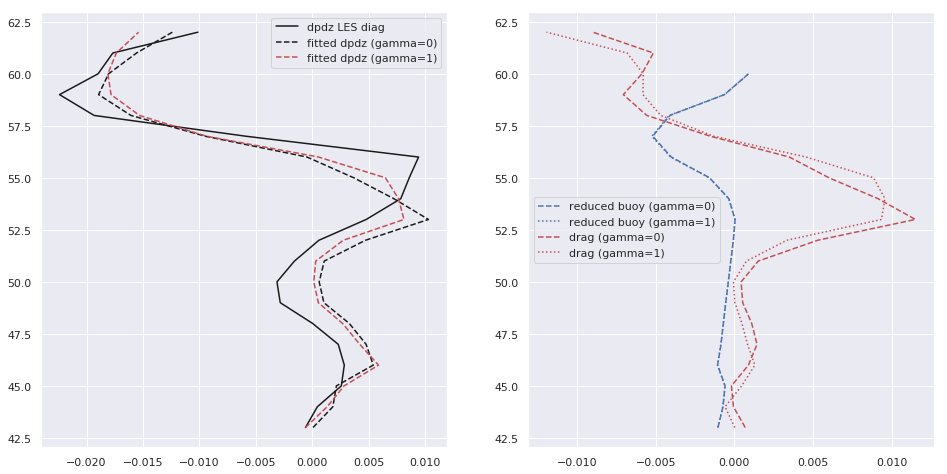

In [13]:
# plot updraft 3 
fig, ax = plt.subplots(1,2,figsize=(16,8))

ax[0].plot(-upd3['pz'], upd3['zidx'], 'k')
ax[0].plot(-upd3['pz_pred1'], upd3['zidx'], 'k--')
ax[0].plot(-upd3['pz_pred2'], upd3['zidx'], 'r--')
ax[0].legend(['dpdz LES diag','fitted dpdz (gamma=0)','fitted dpdz (gamma=1)'])

ax[1].plot(-upd3['b_coeff1']*upd2['br'], upd3['zidx'], 'b--')
ax[1].plot(-upd3['b_coeff2']*upd2['br'], upd3['zidx'], 'b:')
ax[1].plot(lsq3_1.x[2]*upd3['area_w'], upd3['zidx'], 'r--')
ax[1].plot(lsq3_2.x[2]*(upd3['area_w']-upd3['half_dwu2dz']), upd3['zidx'], 'r:')
ax[1].legend(['reduced buoy (gamma=0)','reduced buoy (gamma=1)','drag (gamma=0)','drag (gamma=1)'])

plt.show()


In [14]:
# append data of all three updrafts and fit the coeff
upds = upd1[['pz','br','aspect_ratio','area_w','half_dwu2dz','zidx']]
upds = upds.append(upd2[['pz','br','aspect_ratio','area_w','half_dwu2dz','zidx']], ignore_index=True)
upds = upds.append(upd3[['pz','br','aspect_ratio','area_w','half_dwu2dz','zidx']], ignore_index=True)

def fun(coeff, x, y):
    return coeff[0]*x['br']/(1+coeff[1]*x['aspect_ratio']**2) - coeff[2]*x['area_w'] - y

lsq_1 = least_squares(fun, [0.75,0.5,0.5], args=(upds[['br','aspect_ratio','area_w']], upds['pz']))
upd1['pz_pred1_all3'] = lsq_1.x[0]*upd1['br']/(1+lsq_1.x[1]*upd1['aspect_ratio']**2)-lsq_1.x[2]*upd1['area_w']
upd2['pz_pred1_all3'] = lsq_1.x[0]*upd2['br']/(1+lsq_1.x[1]*upd2['aspect_ratio']**2)-lsq_1.x[2]*upd2['area_w']
upd3['pz_pred1_all3'] = lsq_1.x[0]*upd3['br']/(1+lsq_1.x[1]*upd3['aspect_ratio']**2)-lsq_1.x[2]*upd3['area_w']

def fun(coeff, x, y):
    return coeff[0]*x['br']/(1+coeff[1]*x['aspect_ratio']**2) - coeff[2]*(x['area_w']-x['half_dwu2dz']) - y

lsq_2 = least_squares(fun, [0.75,0.5,0.5], args=(upds[['br','aspect_ratio','area_w','half_dwu2dz']], upds['pz']))
upd1['pz_pred2_all3'] = lsq_2.x[0]*upd1['br']/(1+lsq_2.x[1]*upd1['aspect_ratio']**2)-lsq_2.x[2]*(upd1['area_w']-upd1['half_dwu2dz'])
upd2['pz_pred2_all3'] = lsq_2.x[0]*upd2['br']/(1+lsq_2.x[1]*upd2['aspect_ratio']**2)-lsq_2.x[2]*(upd2['area_w']-upd2['half_dwu2dz'])
upd3['pz_pred2_all3'] = lsq_2.x[0]*upd3['br']/(1+lsq_2.x[1]*upd3['aspect_ratio']**2)-lsq_2.x[2]*(upd3['area_w']-upd3['half_dwu2dz'])



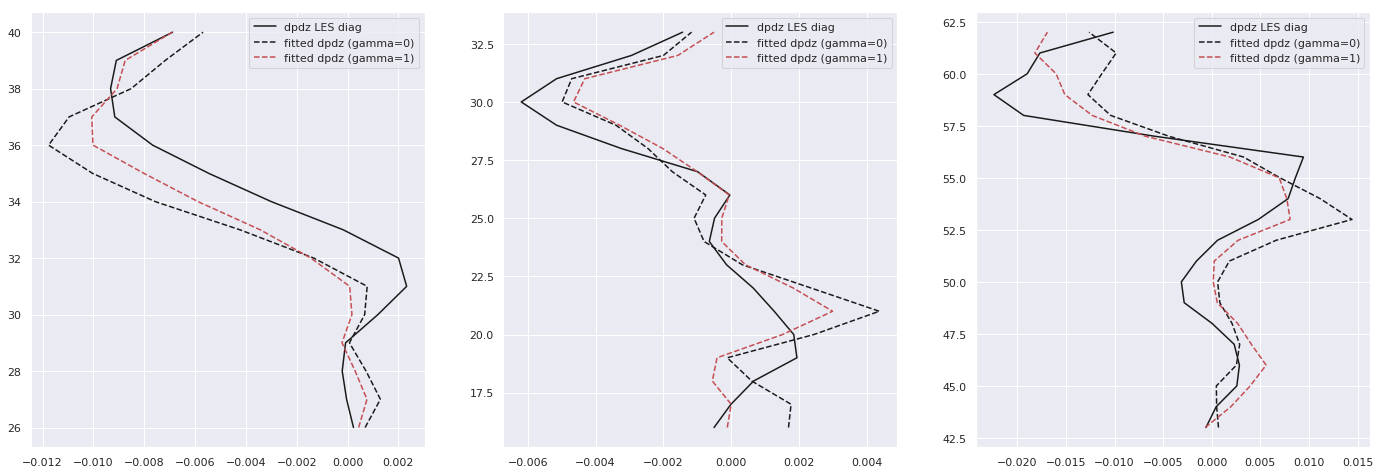

In [15]:
# plot 
fig, ax = plt.subplots(1,3,figsize=(24,8))

ax[0].plot(-upd1['pz'], upd1['zidx'], 'k')
ax[0].plot(-upd1['pz_pred1_all3'], upd1['zidx'], 'k--')
ax[0].plot(-upd1['pz_pred2_all3'], upd1['zidx'], 'r--')
ax[0].legend(['dpdz LES diag','fitted dpdz (gamma=0)','fitted dpdz (gamma=1)'])

ax[1].plot(-upd2['pz'], upd2['zidx'], 'k')
ax[1].plot(-upd2['pz_pred1_all3'], upd2['zidx'], 'k--')
ax[1].plot(-upd2['pz_pred2_all3'], upd2['zidx'], 'r--')
ax[1].legend(['dpdz LES diag','fitted dpdz (gamma=0)','fitted dpdz (gamma=1)'])

ax[2].plot(-upd3['pz'], upd3['zidx'], 'k')
ax[2].plot(-upd3['pz_pred1_all3'], upd3['zidx'], 'k--')
ax[2].plot(-upd3['pz_pred2_all3'], upd3['zidx'], 'r--')
ax[2].legend(['dpdz LES diag','fitted dpdz (gamma=0)','fitted dpdz (gamma=1)'])

plt.show()


## Use a pair of two updrafts as training set and the rest as validation set

### train with (1,2) and validate with 3

In [16]:
# append data and fit the coeff
upd12 = upd1[['pz','br','aspect_ratio','area_w','half_dwu2dz','zidx']]
upd12 = upds.append(upd2[['pz','br','aspect_ratio','area_w','half_dwu2dz','zidx']], ignore_index=True)

def fun(coeff, x, y):
    return coeff[0]*x['br']/(1+coeff[1]*x['aspect_ratio']**2) - coeff[2]*x['area_w'] - y

lsq12_1 = least_squares(fun, [0.75,0.5,0.5], args=(upd12[['br','aspect_ratio','area_w']], upd12['pz']))
upd3['pz_pred1_12'] = lsq12_1.x[0]*upd3['br']/(1+lsq12_1.x[1]*upd3['aspect_ratio']**2)-lsq12_1.x[2]*upd3['area_w']

def fun(coeff, x, y):
    return coeff[0]*x['br']/(1+coeff[1]*x['aspect_ratio']**2) - coeff[2]*(x['area_w']-x['half_dwu2dz']) - y

lsq12_2 = least_squares(fun, [0.75,0.5,0.5], args=(upd12[['br','aspect_ratio','area_w','half_dwu2dz']], upd12['pz']))
upd3['pz_pred2_12'] = lsq12_2.x[0]*upd3['br']/(1+lsq12_2.x[1]*upd3['aspect_ratio']**2)-lsq12_2.x[2]*(upd3['area_w']-upd3['half_dwu2dz'])



### train with (1,3) and validate with 2

In [17]:
# append data and fit the coeff
upd13 = upd1[['pz','br','aspect_ratio','area_w','half_dwu2dz','zidx']]
upd13 = upds.append(upd3[['pz','br','aspect_ratio','area_w','half_dwu2dz','zidx']], ignore_index=True)

def fun(coeff, x, y):
    return coeff[0]*x['br']/(1+coeff[1]*x['aspect_ratio']**2) - coeff[2]*x['area_w'] - y

lsq13_1 = least_squares(fun, [0.75,0.5,0.5], args=(upd13[['br','aspect_ratio','area_w']], upd13['pz']))
upd2['pz_pred1_13'] = lsq13_1.x[0]*upd2['br']/(1+lsq13_1.x[1]*upd2['aspect_ratio']**2)-lsq13_1.x[2]*upd2['area_w']

def fun(coeff, x, y):
    return coeff[0]*x['br']/(1+coeff[1]*x['aspect_ratio']**2) - coeff[2]*(x['area_w']-x['half_dwu2dz']) - y

lsq13_2 = least_squares(fun, [0.75,0.5,0.5], args=(upd13[['br','aspect_ratio','area_w','half_dwu2dz']], upd13['pz']))
upd2['pz_pred2_13'] = lsq13_2.x[0]*upd2['br']/(1+lsq13_2.x[1]*upd2['aspect_ratio']**2)-lsq13_2.x[2]*(upd2['area_w']-upd2['half_dwu2dz'])



### train with (2,3) and validate with 1

In [18]:
# append data and fit the coeff
upd23 = upd2[['pz','br','aspect_ratio','area_w','half_dwu2dz','zidx']]
upd23 = upds.append(upd3[['pz','br','aspect_ratio','area_w','half_dwu2dz','zidx']], ignore_index=True)

def fun(coeff, x, y):
    return coeff[0]*x['br']/(1+coeff[1]*x['aspect_ratio']**2) - coeff[2]*x['area_w'] - y

lsq23_1 = least_squares(fun, [0.75,0.5,0.5], args=(upd23[['br','aspect_ratio','area_w']], upd23['pz']))
upd1['pz_pred1_23'] = lsq23_1.x[0]*upd1['br']/(1+lsq23_1.x[1]*upd1['aspect_ratio']**2)-lsq23_1.x[2]*upd1['area_w']

def fun(coeff, x, y):
    return coeff[0]*x['br']/(1+coeff[1]*x['aspect_ratio']**2) - coeff[2]*(x['area_w']-x['half_dwu2dz']) - y

lsq23_2 = least_squares(fun, [0.75,0.5,0.5], args=(upd23[['br','aspect_ratio','area_w','half_dwu2dz']], upd23['pz']))
upd1['pz_pred2_23'] = lsq23_2.x[0]*upd1['br']/(1+lsq23_2.x[1]*upd1['aspect_ratio']**2)-lsq23_2.x[2]*(upd1['area_w']-upd1['half_dwu2dz'])



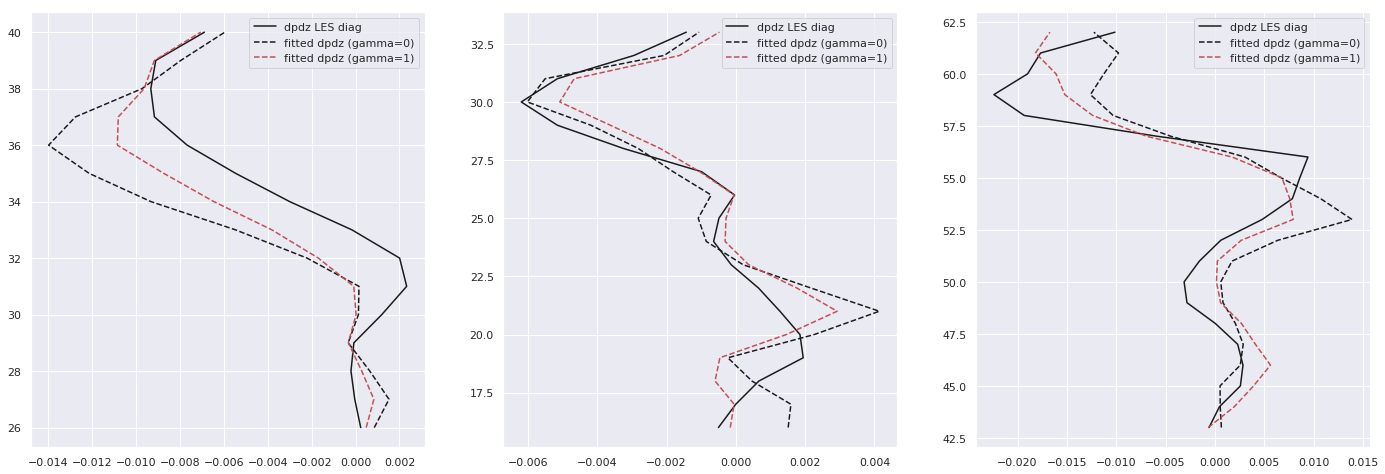

In [22]:
# plot 
fig, ax = plt.subplots(1,3,figsize=(24,8))

ax[0].plot(-upd1['pz'], upd1['zidx'], 'k')
ax[0].plot(-upd1['pz_pred1_23'], upd1['zidx'], 'k--')
ax[0].plot(-upd1['pz_pred2_23'], upd1['zidx'], 'r--')
ax[0].legend(['dpdz LES diag','fitted dpdz (gamma=0)','fitted dpdz (gamma=1)'])

ax[1].plot(-upd2['pz'], upd2['zidx'], 'k')
ax[1].plot(-upd2['pz_pred1_13'], upd2['zidx'], 'k--')
ax[1].plot(-upd2['pz_pred2_13'], upd2['zidx'], 'r--')
ax[1].legend(['dpdz LES diag','fitted dpdz (gamma=0)','fitted dpdz (gamma=1)'])

ax[2].plot(-upd3['pz'], upd3['zidx'], 'k')
ax[2].plot(-upd3['pz_pred1_12'], upd3['zidx'], 'k--')
ax[2].plot(-upd3['pz_pred2_12'], upd3['zidx'], 'r--')
ax[2].legend(['dpdz LES diag','fitted dpdz (gamma=0)','fitted dpdz (gamma=1)'])

plt.show()

In [24]:
print lsq_2.x
print lsq12_2.x
print lsq13_2.x
print lsq23_2.x

[9.49539306e-01 2.62888475e-04 3.65369528e-01]
[9.99593445e-01 3.00553897e-04 3.60866419e-01]
[1.09828858e+00 3.86965824e-04 3.63385514e-01]
[1.09828858e+00 3.86965824e-04 3.63385514e-01]


# Apply lsq_2 onto the bulk plume

In [25]:
# updraft filter
xidx = np.arange(nx)
yidx = np.arange(ny)
zidx = np.arange(nz)
xmesh = np.repeat(xidx,len(yidx)).reshape(len(xidx),len(yidx))
ymesh = np.repeat(yidx,len(xidx)).reshape(len(yidx),len(xidx)).transpose()
mask3d_upd = mask3d['updraft'][xmesh,ymesh,:]

br_upd = np.ma.masked_where(mask3d_upd, br_centr[xmesh,ymesh,:]).mean(axis=0).mean(axis=0)
w_upd = np.ma.masked_where(mask3d_upd, w_centr[xmesh,ymesh,:]).mean(axis=0).mean(axis=0)
w_upd_sq = w_upd**2
a_upd = 1-mask3d_upd.sum(axis=0).sum(axis=0)/float(len(xidx)*len(yidx))

# compute derivatives
pz = np.zeros_like(p_centr)
dwudz = np.zeros(nz)
dwu2dz = np.zeros(nz)
dawu2dz = np.zeros(nz)
az = np.zeros(nz)
for k in np.arange(1,nz-1):
    pz[:,:,k] = 0.5*(alpha0[k+1]*p_centr[:,:,k+1]-alpha0[k-1]*p_centr[:,:,k-1])/float(dz)
    dwudz[k] = 0.5*(w_upd[k+1]-w_upd[k-1])/float(dz)
    dwu2dz[k] = 0.5*(w_upd_sq[k+1]-w_upd_sq[k-1])/float(dz)
    dawu2dz[k] = 0.5*(a_upd[k+1]*w_upd_sq[k+1]-a_upd[k-1]*w_upd_sq[k-1])/float(dz)
    az[k] = 0.5*(a_upd[k+1]-a_upd[k-1])/float(dz)
pz_upd = np.ma.masked_where(mask3d_upd, pz[xmesh,ymesh,:]).mean(axis=0).mean(axis=0)

H = (a_upd[zidx]!=0).sum() * dz
R1 = np.sqrt(a_upd*len(xidx)*len(yidx)/3.1415926)
R2 = np.sqrt(a_upd)*500

/home/jiahe/.virtualenvs/diag/lib/python2.7/site-packages/ipykernel_launcher.py:22: UserWarning: Warning: converting a masked element to nan.
/home/jiahe/.virtualenvs/diag/lib/python2.7/site-packages/ipykernel_launcher.py:23: UserWarning: Warning: converting a masked element to nan.
/home/jiahe/.virtualenvs/diag/lib/python2.7/site-packages/ipykernel_launcher.py:24: UserWarning: Warning: converting a masked element to nan.
/home/jiahe/.virtualenvs/diag/lib/python2.7/site-packages/ipykernel_launcher.py:22: UserWarning: Warning: converting a masked element to nan.
/home/jiahe/.virtualenvs/diag/lib/python2.7/site-packages/ipykernel_launcher.py:23: UserWarning: Warning: converting a masked element to nan.
/home/jiahe/.virtualenvs/diag/lib/python2.7/site-packages/ipykernel_launcher.py:24: UserWarning: Warning: converting a masked element to nan.
/home/jiahe/.virtualenvs/diag/lib/python2.7/site-packages/ipykernel_launcher.py:22: UserWarning: Warning: converting a masked element to nan.
/home/

In [26]:
# fit the equation: (dp/dz)i = α1 / [1+α2*{aspect_ratio}^2] * b_i - β [1/a_i d(a_i w_i^2)/dz - 1/2 d(w_i^2)/dz]
bulk = pd.DataFrame(pz_upd[zidx], columns=['pz'])
bulk['br'] = br_upd[zidx]
bulk['aspect_ratio1'] = 0.5*H/R1[zidx]
bulk['aspect_ratio2'] = 0.5*H/R2[zidx]
bulk['area_w'] = dawu2dz[zidx]/a_upd[zidx]
bulk['half_dwu2dz'] = 0.5*dwu2dz[zidx]
bulk['zidx'] = zidx

bulk = bulk.dropna()

bulk['pz_pred_R1'] = lsq_2.x[0]*bulk['br']/(1+lsq_2.x[1]*bulk['aspect_ratio1']**2)-lsq_2.x[2]*(bulk['area_w']-bulk['half_dwu2dz'])
bulk['pz_pred_R2'] = lsq_2.x[0]*bulk['br']/(1+lsq_2.x[1]*bulk['aspect_ratio2']**2)-lsq_2.x[2]*(bulk['area_w']-bulk['half_dwu2dz'])



/home/jiahe/.virtualenvs/diag/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in divide
  after removing the cwd from sys.path.
/home/jiahe/.virtualenvs/diag/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in divide
  """
/home/jiahe/.virtualenvs/diag/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in divide
  


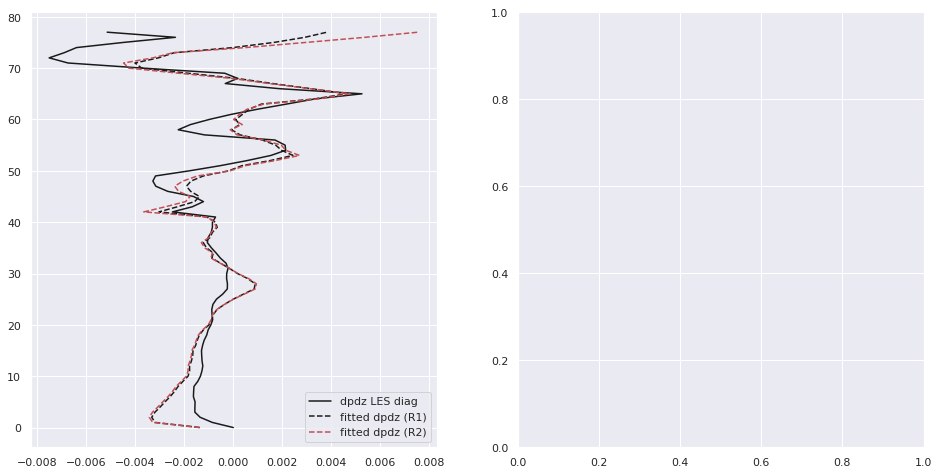

In [27]:
# plot 
fig, ax = plt.subplots(1,2,figsize=(16,8))

ax[0].plot(-bulk['pz'], bulk['zidx'], 'k')
ax[0].plot(-bulk['pz_pred_R1'], bulk['zidx'], 'k--')
ax[0].plot(-bulk['pz_pred_R2'], bulk['zidx'], 'r--')
ax[0].legend(['dpdz LES diag','fitted dpdz (R1)','fitted dpdz (R2)'])

plt.show()